# OceanParcels with 3D regridded FESOM data

In [1]:
import xarray as xr
import cmocean as cmo

from datetime import datetime, timedelta

import numpy as np

import parcels

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

In [2]:
inpath = "/albedo/work/user/quraus001/processed_data/gridded/"

glob.glob(inpath + "*.nc")

['/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded_3d_new2.nc',
 '/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_time_const-v-0.4_transposed.nc',
 '/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded_3d_positive.nc',
 '/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_converted-time_gradient-test.nc',
 '/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded_3d_T30.nc',
 '/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded_3d_T2.nc',
 '/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded_withdepth_float.nc',
 '/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded_3d_new.nc',
 '/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_time_const-v-0.4.nc',
 '/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_time_const-v0.2

In [3]:
inpath = "/albedo/work/user/quraus001/processed_data/gridded/"

file = "Arc40.2002.oce.mean.sub_gridded_3d_T30.nc" 
ds_model = xr.open_dataset(inpath + file)

outpath  = "/albedo/home/quraus001/FESOM-FS-subduction/outdata/"
outfname = f"test_2d"
outfile  = f"{outpath}{outfname}.zarr"

## Look at model data

In [6]:
ds_model

<xarray.Dataset> Size: 36GB
Dimensions:  (time: 30, z: 45, lat: 825, lon: 800)
Coordinates:
  * time     (time) object 240B 2002-01-01 23:57:30 ... 2002-01-30 23:57:30
  * z        (z) float64 360B 0.0 10.0 20.0 30.0 ... 5.15e+03 5.4e+03 5.65e+03
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0
Data variables:
    temp     (time, z, lat, lon) float64 7GB ...
    salt     (time, z, lat, lon) float64 7GB ...
    u        (time, z, lat, lon) float64 7GB ...
    v        (time, z, lat, lon) float64 7GB ...
    w        (time, z, lat, lon) float64 7GB ...

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 2., 1., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(800, 10)),
 array([-3.50365270e-04, -2.84741499e-04, -2.19117728e-04, -1.53493957e-04,
        -8.78701860e-05, -2.22464150e-05,  4.33773559e-05,  1.09001127e-04,
         1.74624898e-04,  2.40248669e-04,  3.05872440e-04]),
 <a list of 800 BarContainer objects>)

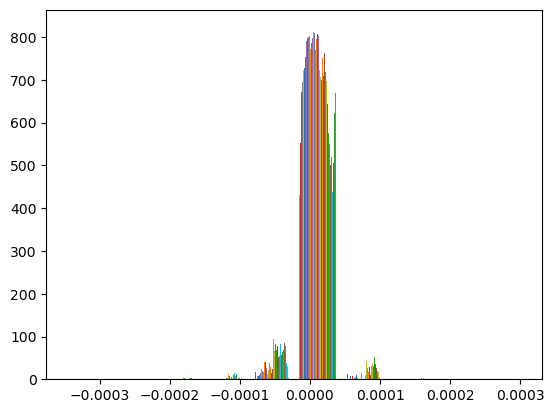

In [7]:
plt.hist(ds_model.w.isel(time=0, z=0))

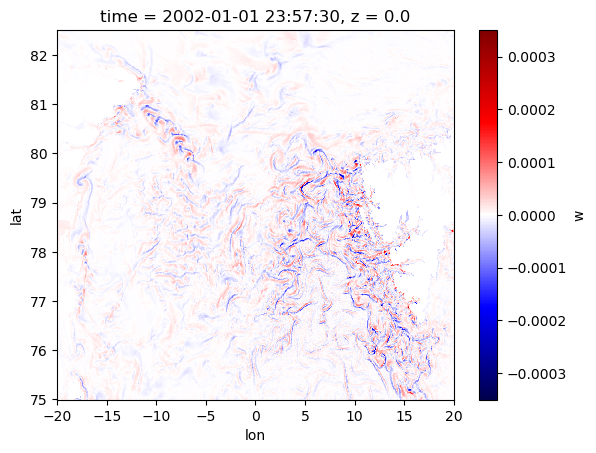

In [10]:
ds_model.w.isel(time=0, z=0).plot(cmap="seismic")

Text(0.5, 1.0, 'Temperature Section at 79°N')

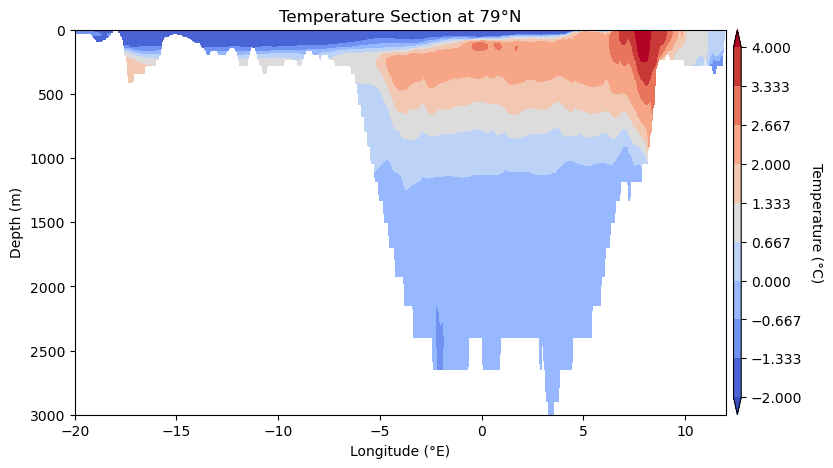

In [11]:
var = "temp"  # variable to plot
vmin, vmax = -0.001, 0.001  # colorbar limits
vmin, vmax = -2, 4  # colorbar limits


levels = np.linspace(vmin, vmax, 10)  # contour levels

# contour plot of section at 79N at first time step
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.contourf(ds_model.lon, ds_model.z, ds_model[var].isel(time=0).sel(lat=79, method="nearest").values[:, :],
           levels=levels, cmap="coolwarm", extend='both')
ax.set_ylim(3000, 0)
ax.set_xlim(-20, 12)

# add colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.01, aspect=50)
cbar.set_label('Temperature (°C)', rotation=270, labelpad=15)

# add labels and title
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Depth (m)')
ax.set_title('Temperature Section at 79°N')

In [9]:
ds_model['z'].values

array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.,  115.,  135.,  160.,  190.,  230.,  280.,  340.,
        410.,  490.,  580.,  680.,  790.,  910., 1040., 1180., 1330.,
       1500., 1700., 1920., 2150., 2400., 2650., 2900., 3150., 3400.,
       3650., 3900., 4150., 4400., 4650., 4900., 5150., 5400., 5650.])

In [19]:
ds_model['z'] = abs(ds_model['z'].values)  # make depth positive
# save dataset to netcdf
ds_model.to_netcdf(inpath +"Arc40.2002.oce.mean.sub_gridded_3d_positive.nc")

## Parcels Setup

In [4]:
filenames = {
    'U': inpath +file,
    'V': inpath +file,
    "T": inpath +file,
    #"S": inpath +file,
    "W": inpath +file,
}

variables = {
    'U': 'u',
    'V': 'v',
    "T": 'temp',
    #"S": 'salt',
    "W": 'w',
}

dimensions = {
    'time': 'time',
    'lon': 'lon',
    'lat': 'lat',
    'depth': 'z',
}

fieldset = parcels.FieldSet.from_netcdf(
    filenames,
    variables,
    dimensions,
    mesh='spherical',  # or flat
    allow_time_extrapolation=True
)

In [5]:
from parcels import AdvectionRK4
from parcels import JITParticle, Variable

# STEP 1: Set up your particle release locations
n = 10                               # number of particles 
d = 100
lons = np.linspace(0,11,n)#np.full(n, 3)                 
lats = np.full(n, 78.3)#np.linspace(78, 80, n)
depths = np.full(n, d)           # all at 100m depth (fixed layer)

#from datetime import timedelta

#start_datetime = fieldset.time_origin.time_origin + timedelta(days=90)
#start_time = (start_datetime - fieldset.time_origin.fulltime).total_seconds()
start_time_numerical = fieldset.U.grid.time[0] # This will be 0.0 in your case

# STEP 2: Define a custom particle class
class SampleParticle(JITParticle):
    #vorticity = Variable('vorticity', dtype=np.float32)
    temperature = Variable('temperature', dtype=np.float32, initial=np.nan)
    #salinity    = Variable('salinity', dtype=np.float32, initial=np.nan)
    velocity    = Variable('velocity', dtype=np.float32, initial=np.nan)
    d           = Variable('d', dtype=np.float32, initial=0.0)
    u           = Variable('u', dtype=np.float32, initial=np.nan)
    v           = Variable('v', dtype=np.float32, initial=np.nan)
    w           = Variable('w', dtype=np.float32, initial=np.nan)



pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,
    pclass=SampleParticle,#parcels.JITParticle,
    lon=lons,
    lat=lats,
    depth=depths,
    #time = np.full(n, start_time_numerical)
    #allow_time_extrapolation=True
)

In [6]:
def SampleTS(particle, fieldset, time):
    particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]
    #particle.salinity = fieldset.S[time, particle.depth, particle.lat, particle.lon]

def SampleVelocity(particle, fieldset, time):
    (particle.u, particle.v, particle.w) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]
    particle.velocity = (particle.u**2 + particle.v**2 + particle.w**2)**0.5

#def SampleDepth(particle, fieldset, time):
#    particle.d = particle.depth  # fixed depth layer

#def SurfaceBound(particle, fieldset, time):
#    if particle.depth < 0:
#        particle.depth = 0

In [7]:
pset.execute(
    [AdvectionRK4, SampleTS, SampleVelocity],
    runtime=timedelta(days=30),  #100           
    dt=timedelta(minutes=30),              
    output_file=pset.ParticleFile(name=outfname, outputdt=timedelta(hours=12)) #hours=12
)

INFO: Output files are stored in test_2d.zarr.
100%|██████████| 2592000.0/2592000.0 [00:48<00:00, 53467.03it/s]


In [8]:
# function to convert .zarr to netcdf without dask array chunks
import xarray as xr
import shutil

def zarr_to_netcdf(zarr_file, netcdf_file, delete=False):
    """
    Convert a Zarr file to NetCDF format using xarray.
    Args:
        zarr_file (str): Path to the input Zarr file.
        netcdf_file (str): Path to the output NetCDF file.
        delete (bool): If True, delete the original Zarr file after conversion.
    """

    # Open the Zarr file
    ds = xr.open_zarr(zarr_file, consolidated=True)

    # Convert to NetCDF
    ds.to_netcdf(netcdf_file)

    # Close the dataset
    ds.close()
    # Optionally delete the original Zarr file
    if delete:
        
        shutil.rmtree(zarr_file)
        print(f"Deleted Zarr file: {zarr_file}")

In [9]:
try:
    ds.close()
except:
    print("ds.close() failed, but that's okay. It might be already closed.")
#outfname = "output_debug_velocities_spherical"
zarr_to_netcdf(outfname + ".zarr", outfname + ".nc", delete=True)

ds.close() failed, but that's okay. It might be already closed.
Deleted Zarr file: test_2d.zarr


In [10]:
ds = xr.open_dataset(outfname + ".nc")
ds#.lon.isel(trajectory=5).plot(x = "obs")

<xarray.Dataset> Size: 27kB
Dimensions:      (trajectory: 10, obs: 60)
Coordinates:
  * obs          (obs) int32 240B 0 1 2 3 4 5 6 7 8 ... 52 53 54 55 56 57 58 59
  * trajectory   (trajectory) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    d            (trajectory, obs) float32 2kB ...
    lat          (trajectory, obs) float32 2kB ...
    lon          (trajectory, obs) float32 2kB ...
    temperature  (trajectory, obs) float32 2kB ...
    time         (trajectory, obs) object 5kB ...
    u            (trajectory, obs) float32 2kB ...
    v            (trajectory, obs) float32 2kB ...
    velocity     (trajectory, obs) float32 2kB ...
    w            (trajectory, obs) float32 2kB ...
    z            (trajectory, obs) float32 2kB ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4SampleTSSampleVelocity
    parcels_mesh:           spherical
    parcels_version:        3.1.2

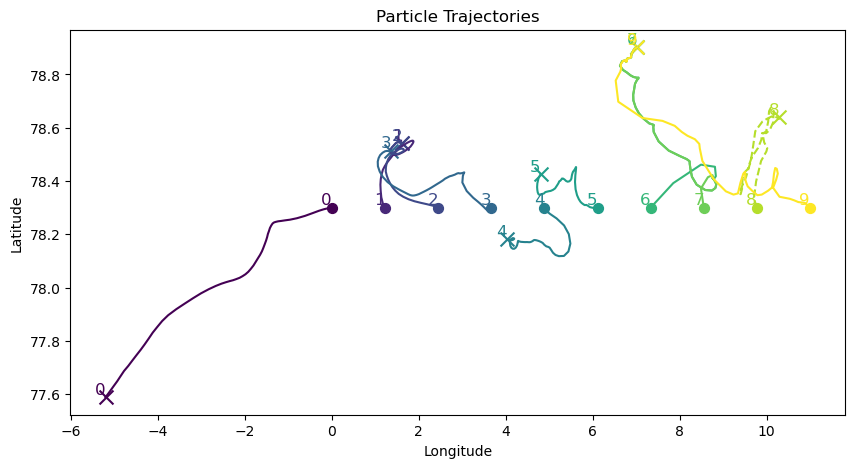

In [11]:
# create list with 10 colors for the trajectories
colors = plt.cm.viridis(np.linspace(0, 1, len(ds.trajectory)))

plt.figure(figsize=(10, 5)) 


for i, pid in enumerate(ds.trajectory[:]):
    if pid.item() == 8:  # plot with dashed line
        plt.plot(ds.lon.sel(trajectory=pid), ds.lat.sel(trajectory=pid), label=f"Trajectory {pid.item()}", color=colors[i], linestyle='--')
    else:  # plot with solid line
        plt.plot(ds.lon.sel(trajectory=pid), ds.lat.sel(trajectory=pid), label=f"Trajectory {pid.item()}", color=colors[i])
    # scatter the first and last points
    plt.scatter(ds.lon.isel(trajectory=pid, obs=0), ds.lat.isel(trajectory=pid, obs=0), color=colors[i], s=50)
    plt.scatter(ds.lon.isel(trajectory=pid, obs=ds.obs[-1]), ds.lat.isel(trajectory=pid, obs=ds.obs[-1]), color=colors[i], s=100, marker="x")
    # write the number of the trajectory at the first and last point
    plt.text(ds.lon.isel(trajectory=pid, obs=0), ds.lat.isel(trajectory=pid, obs=0), f"{pid.item()}", fontsize=12, ha='right', va='bottom', color=colors[i])
    plt.text(ds.lon.isel(trajectory=pid, obs=ds.obs[-1]), ds.lat.isel(trajectory=pid, obs=ds.obs[-1]), f"{pid.item()}", fontsize=12, ha='right', va='bottom', color=colors[i])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Particle Trajectories")
#plt.legend()
plt.show()

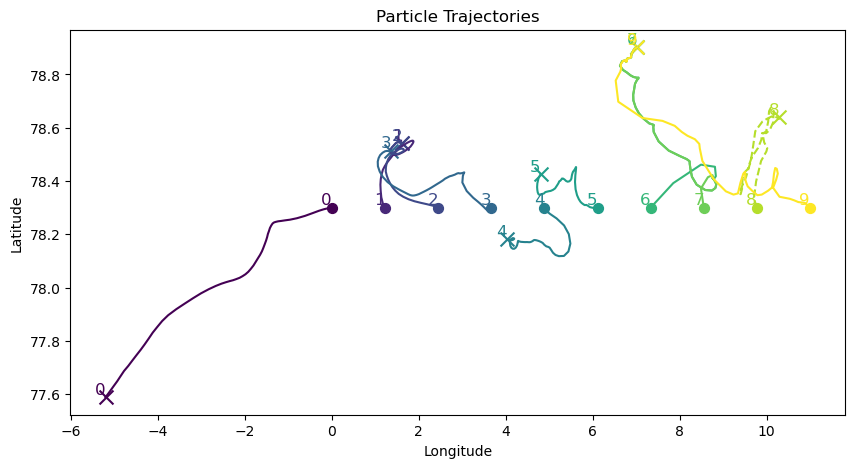

In [12]:
# create list with 10 colors for the trajectories
colors = plt.cm.viridis(np.linspace(0, 1, len(ds.trajectory)))

plt.figure(figsize=(10, 5)) 


for i, pid in enumerate(ds.trajectory[:]):
    if pid.item() == 8:  # plot with dashed line
        plt.plot(ds.lon.sel(trajectory=pid), ds.lat.sel(trajectory=pid), label=f"Trajectory {pid.item()}", color=colors[i], linestyle='--')
    else:  # plot with solid line
        plt.plot(ds.lon.sel(trajectory=pid), ds.lat.sel(trajectory=pid), label=f"Trajectory {pid.item()}", color=colors[i])
    # scatter the first and last points
    plt.scatter(ds.lon.isel(trajectory=pid, obs=0), ds.lat.isel(trajectory=pid, obs=0), color=colors[i], s=50)
    plt.scatter(ds.lon.isel(trajectory=pid, obs=ds.obs[-1]), ds.lat.isel(trajectory=pid, obs=ds.obs[-1]), color=colors[i], s=100, marker="x")
    # write the number of the trajectory at the first and last point
    plt.text(ds.lon.isel(trajectory=pid, obs=0), ds.lat.isel(trajectory=pid, obs=0), f"{pid.item()}", fontsize=12, ha='right', va='bottom', color=colors[i])
    plt.text(ds.lon.isel(trajectory=pid, obs=ds.obs[-1]), ds.lat.isel(trajectory=pid, obs=ds.obs[-1]), f"{pid.item()}", fontsize=12, ha='right', va='bottom', color=colors[i])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Particle Trajectories")
#plt.legend()
plt.show()

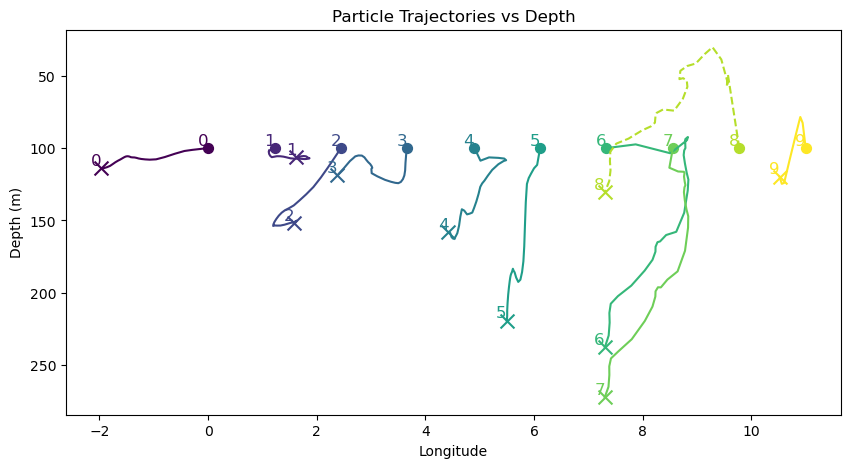

In [13]:
# Repeat same plot but lon vs depth

colors = plt.cm.viridis(np.linspace(0, 1, len(ds.trajectory)))

plt.figure(figsize=(10, 5)) 
for i, pid in enumerate(ds.trajectory[:]):
    if pid.item() == 8:  # plot with dashed line
        plt.plot(ds.lon.sel(trajectory=pid), ds.z.sel(trajectory=pid), label=f"Trajectory {pid.item()}", color=colors[i], linestyle='--')
    else:  # plot with solid line
        plt.plot(ds.lon.sel(trajectory=pid), ds.z.sel(trajectory=pid), label=f"Trajectory {pid.item()}", color=colors[i])
    # scatter the first and last points
    plt.scatter(ds.lon.isel(trajectory=pid, obs=0), ds.z.isel(trajectory=pid, obs=0), color=colors[i], s=50)
    plt.scatter(ds.lon.isel(trajectory=pid, obs=ds.obs[-1]), ds.z.isel(trajectory=pid, obs=ds.obs[-1]), color=colors[i], s=100, marker="x")
    # write the number of the trajectory at the first and last point
    plt.text(ds.lon.isel(trajectory=pid, obs=0), ds.z.isel(trajectory=pid, obs=0), f"{pid.item()}", fontsize=12, ha='right', va='bottom', color=colors[i])
    plt.text(ds.lon.isel(trajectory=pid, obs=ds.obs[-1]), ds.z.isel(trajectory=pid, obs=ds.obs[-1]), f"{pid.item()}", fontsize=12, ha='right', va='bottom', color=colors[i])
plt.xlabel("Longitude")
plt.ylabel("Depth (m)")
plt.title("Particle Trajectories vs Depth")
plt.gca().invert_yaxis()  # Invert y-axis to have depth increasing downwards
plt.show()

In [15]:
velocity

<xarray.DataArray (z: 45, lat: 825, lon: 800)> Size: 238MB
array([[[       nan, 0.01295048, 0.01295048, ..., 0.18989915,
         0.18622826, 0.18622826],
        [0.01295048, 0.01295048, 0.01295048, ..., 0.18989915,
         0.18989915, 0.18622826],
        [0.00680483, 0.01295048, 0.01295048, ..., 0.18989915,
         0.18989915, 0.18622826],
        ...,
        [0.01227269, 0.01227269, 0.00854672, ..., 0.07051048,
         0.07051048, 0.07001897],
        [0.01227269, 0.01227269, 0.00854672, ..., 0.07051048,
         0.07051048, 0.06808563],
        [0.01227269, 0.01227269, 0.01227269, ..., 0.06795169,
         0.06808563, 0.06808563]],

       [[       nan, 0.01503795, 0.01503795, ..., 0.11988492,
         0.12322749, 0.12322749],
        [0.01503795, 0.01503795, 0.01503795, ..., 0.11988492,
         0.11988492, 0.12322749],
        [0.0068247 , 0.01503795, 0.01503795, ..., 0.11988492,
         0.11988492, 0.12322749],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], shape=(45, 825, 800))
Coordinates:
    time     object 8B 2002-01-21 23:57:30
  * z        (z) float64 360B 0.0 10.0 20.0 30.0 ... 5.15e+03 5.4e+03 5.65e+03
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0

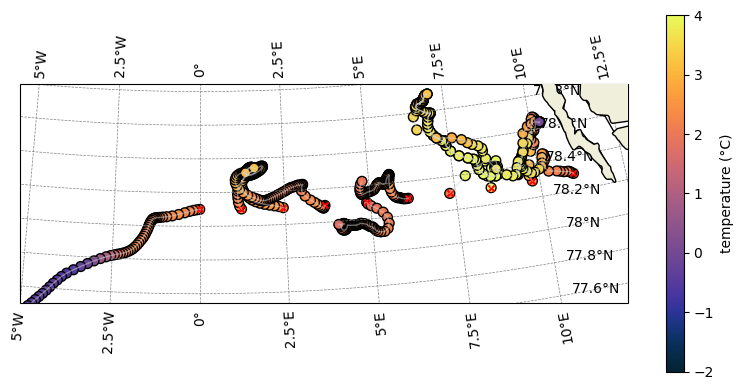

In [12]:
vmin, vmax = 0, 0.3
vmin, vmax = 0, 200
vmin, vmax = -2, 4  # colorbar limits

var = "temperature"  


fig = plt.figure(figsize=(8, 4))
proj = ccrs.NorthPolarStereo()
ax = plt.axes(projection=proj)


# Set extent for Fram Strait (in degrees; note lat/lon in PlateCarree for setting extent)
#ax.set_extent([-20, 20, 75, 82], crs=ccrs.PlateCarree())
ax.set_extent([-5, 12, 77.7, 78.8], crs=ccrs.PlateCarree())
#ax.set_extent([0, 11, 77.5, 81], crs=ccrs.PlateCarree())

#ds_model[var1].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap="coolwarm", vmin=vmin, vmax=vmax, add_colorbar=True)

time_idx = 20
depth    = 10
#velocity = (ds_model.u.isel(time=time_idx, z=depth)**2 + ds_model.v.isel(time=time_idx, z=depth)**2)**0.5
#velocity.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="viridis", vmin=vmin, vmax=0.3, add_colorbar=True)#, vmin=vmin, vmax=vmax, add_colorbar=False)

# Add map features
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
#ax.add_feature(cfeature.OCEAN)

# Plot each particle's trajectory
for pid in ds.trajectory:
    steps = 1
    im = ax.scatter(ds.lon.sel(trajectory=pid)[::steps], ds.lat.sel(trajectory=pid)[::steps], c=ds[var].sel(trajectory=pid)[::steps], cmap=cmo.cm.thermal, alpha=1, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), edgecolor='black', s=50) # 0,5 , vmin=-3.5, vmax=6
    #ax.scatter(ds.lon.sel(trajectory=pid)[0], ds.lat.sel(trajectory=pid)[0], c=ds[var2].sel(trajectory=pid)[0], cmap="coolwarm", alpha=1, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), edgecolor='black', s=50) # 0,5 , vmin=-3.5, vmax=6
    plt.plot(ds.lon.sel(trajectory=pid), ds.lat.sel(trajectory=pid), color="lightgrey", alpha=0.5, linewidth=1, transform=ccrs.PlateCarree())

plt.colorbar(im, label=var + " (°C)")
if True:
    ax.scatter(
    ds.lon.isel(obs=0),
    ds.lat.isel(obs=0),
    color='red',
    s=20,
    transform=ccrs.PlateCarree(),
    label="Start",
    marker="x"
)

#plt.title("Velocity at time index " + str(time_idx) + " (m/s)\n" + var + " field with particle trajectories")
#plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.hist()